In [1]:
import os
import json
import bisect
import re
from pathlib import Path

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

import ipywidgets as widgets
from IPython.display import display, HTML

%matplotlib inline

pd.set_option('mode.chained_assignment', None)

In [2]:
# Creates a dropdown with all the directories located at the "data" directory, so the user
# can select which one to view.
# All the result files generated by the main program are stored inside "data" directory.

basedir = Path("data")
dirs = [entry.name for entry in basedir.iterdir() if entry.is_dir()]
dd = widgets.Dropdown(
    options=sorted(dirs),
    description='Directory:'
)
display(dd)

Dropdown(description='Directory:', options=('BT', 'BT_bigLR_lowEpsDec', 'BT_bigRounds', 'BT_bigRounds_eqPriExp…

In [3]:
# Files are divided into "metadata files", which are stored in JSON format, and "data files",
# which are store in CSV format.
# Data files contain all the states registered and replayed by the AI while training, while
# the metadata ones store all the parameters passed to the AIs at the correspondent data file.

path = basedir / dd.value
metadata_files = []
data_files = []
for f in path.iterdir():
    file_name = f.name
    if file_name.endswith(".json"):
        metadata_files.append(file_name)
    elif file_name.endswith(".csv"):
        data_files.append(file_name)
    else:
        print("Cannot classify file: ", file_name)

In [4]:
# Some custom functions used in this notebook.

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data, dtype=float)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m, m+h

def get_round(times_array):
    def f(time):
        return bisect.bisect_left(times_array, time)
    return f

def get_round_time(times_array):
    def f(time):
        idx = bisect.bisect_left(times_array, time)
        if idx == 0:
            return time
        begin_time = times_array[idx - 1]
        return time - begin_time
    return f

In [5]:
# Reading all metadata files and separating them according to their category.
# There are 3 categories: train metadata, test metadata and fingerprint data.
#   * Train metadata: they contain information about the train params
#   * Test metadata: same as train ones, but for tests
#   * Fingerprint data: They contain information about one state of the result AI after train

runs = 1
metadata = {}
fingerprints = {}
tests = {}
for file_name in metadata_files:
    m = re.match(r"(.*)_(\d+)\(?(\d*)\)?(\..*)$", file_name)
    if m is None:
        print("Cannot parse", file_name)
    else:
        base, num, copy, ext = m.groups()
        num = int(num)
        runs = max(runs, num)
        with open(path / file_name) as f:
            file_dict = json.load(f)
            if copy == "":
                if base == "RunData":
                    metadata[num] = file_dict
                else:
                    fingerprints[num] = file_dict
            else:
                copy = int(copy)
                if tests.get(num) is None:
                    tests[num] = {}
                tests[num][copy] = file_dict

display(pd.DataFrame(metadata[1]["characters_info"]))

Human2  \
type                                                                     Human   
network_id                                                            Human2_1   
team                                                                     team2   
speed                                                                      120   
weight                                                                       1   
max_life                                                                    30   
damage                                                                      10   
defense                                                                      0   
controller_type                                                              1   
controller_name                                                       Basic BT   
ai_type                                                                      4   
reward_func                  sign((e_{n-1}-e_{n})/e_{n-1}-(s_{n-1}-s_{n})/s...   
learning_activated                                                       False   
discount                                                                     0   
max_learning_rate                                                            0   
min_learning_rate                                                            0   
learning_rate_decay_time                                                     0   
learning_interpolator               res://Structures/PolynomialInterpolator.gd   
max_exploration_rate                                                         1   
min_exploration_rate                                                       0.3   
exploration_rate_decay_time                                                  0   
exploration_interpolator                res://Structures/RandomInterpolator.gd   
max_idle_rate                                                                1   
min_idle_rate                                                                0   
idle_rate_decay_time                                                         0   
idle_interpolator                       res://Structures/RandomInterpolator.gd   
experience_replay                                                        False   
experience_sample_size                                                       0   
experience_size_limit                                                       -1   
prioritization                                                           False   
priority_exponent                                                            0   
weight_exponent                                                              0   
num_freeze_iter                                                              1   
think_time                                                                 0.1   
learn_time                                                                   0   
features                     [POS_X_DIFF, POS_Y_DIFF, SELF_X_DIR, SELF_Y_DI...   

                                                                       Goblin1  
type                                                                    Goblin  
network_id                                                           Goblin1_1  
team                                                                     team1  
speed                                                                      120  
weight                                                                       1  
max_life                                                                    30  
damage                                                                      10  
defense                                                                      0  
controller_type                                                              1  
controller_name                                                      Single QL  
ai_type                                                                      1  
reward_func                    (e_{n-1}-e_{n})/e_{n-1}-(s_{n-1}-s

In [6]:
# Loading all the data files, and adding some extra collumns with derived data.
# Informations about the loaded data are printed bellow. 

chars = set()
data_sets = {}
replay_times = {}
terminal_times = {}
test_times = {}
num_tests = 1

for file_name in data_files:
    m = re.match(r"(.*)_(.*?)_(\d+)\(?(\d*)\)?(\..*)$", file_name)
    base, char, run, copy, ext = m.groups()
    run = int(run)
    
    if copy != "":
        num_tests = max(num_tests, int(copy))
        continue
    
    chars.add(char)
    
    data = pd.read_csv(path / file_name)
    
    if data_sets.get(run) is None:
        data_sets[run] = {}
        replay_times[run] = {}
        test_times[run] = {}

    data_sets[run][char] = data

    replays = sorted(data[data["purpuse"] == "replay"]["time"].value_counts().keys().tolist())
    replay_times[run][char] = replays
    
    run_test_times = sorted(data[data["purpuse"] == "test"]["time"].value_counts().keys().tolist())
    test_times[run][char] = run_test_times
    
    terminal_data = data[data["terminal"] == True]
    terminal_count = terminal_data[terminal_data["purpuse"] == "update"]["time"].value_counts()
    terminals = sorted(terminal_count.keys().tolist())
    terminal_times[run] = terminals
    
    discount = metadata[run]["characters_info"][char]["discount"]
    data["pred_reward"] = discount * data["next_val"] * (~ data["terminal"]) - data["q_val"]
    data["label"] = data["reward"] + discount * data["next_val"] * (~ data["terminal"])
    data["loss"] = (data["label"] - data["q_val"])**2
    data["round"] = data["time"].map(get_round(run_test_times))
    data["round_time"] = data["time"].map(get_round_time(run_test_times))
    q_val_cols = data.filter(regex="_q$")
    data["q_avg"] = q_val_cols.mean(axis=1)
    data["q_std"] = q_val_cols.std(axis=1)

num_chars = len(chars)
chars = sorted(list(chars))

print("Number of runs: %d" % runs)
print("Number of tests per run: %d" % num_tests)
print("Number of characters: %d" % len(chars))

display_frame = []
display_index = []
for run in range(1, runs + 1):
    for char in chars:
        data = data_sets[run][char]
        display_frame.append({
            "data_size": data_sets[run][char].shape[0],
            "distinct_rows": len(data[data["purpuse"] == "update"]),
            "replay_rows": len(data[data["purpuse"] == "replay"]),
            "test_rows": len(data[data["purpuse"] == "test"]),
            "terminal_rows": len(terminal_times[run]),
            "replay_samples": len(replay_times[run][char]),
            "test_samples": len(test_times[run][char])
        })
        display_index.append((run, char))
display(pd.DataFrame(display_frame, index=pd.MultiIndex.from_tuples(display_index, names=["run", "char"])))

Number of runs: 8
Number of tests per run: 3
Number of characters: 1


data_size  distinct_rows  replay_rows  test_rows  terminal_rows  \
run char                                                                       
1   Goblin1      58224           9088        26336      22800            120   
2   Goblin1     102610          19658        59552      23400            120   
3   Goblin1     114653          22725        68928      23000            120   
4   Goblin1     120317          23877        73440      23000            120   
5   Goblin1     104536          20304        61632      22600            120   
6   Goblin1      60270           9678        28192      22400            120   
7   Goblin1     108704          21120        64384      23200            120   
8   Goblin1      97939          18715        56224      23000            120   

             replay_samples  test_samples  
run char                                   
1   Goblin1             823           114  
2   Goblin1            1861           117  
3   Goblin1            2154           115  
4   Goblin1            2295           115  
5   Goblin1            1926           113  
6   Goblin1             881           112  
7   Goblin1            2012           116  
8   Goblin1            1757           115

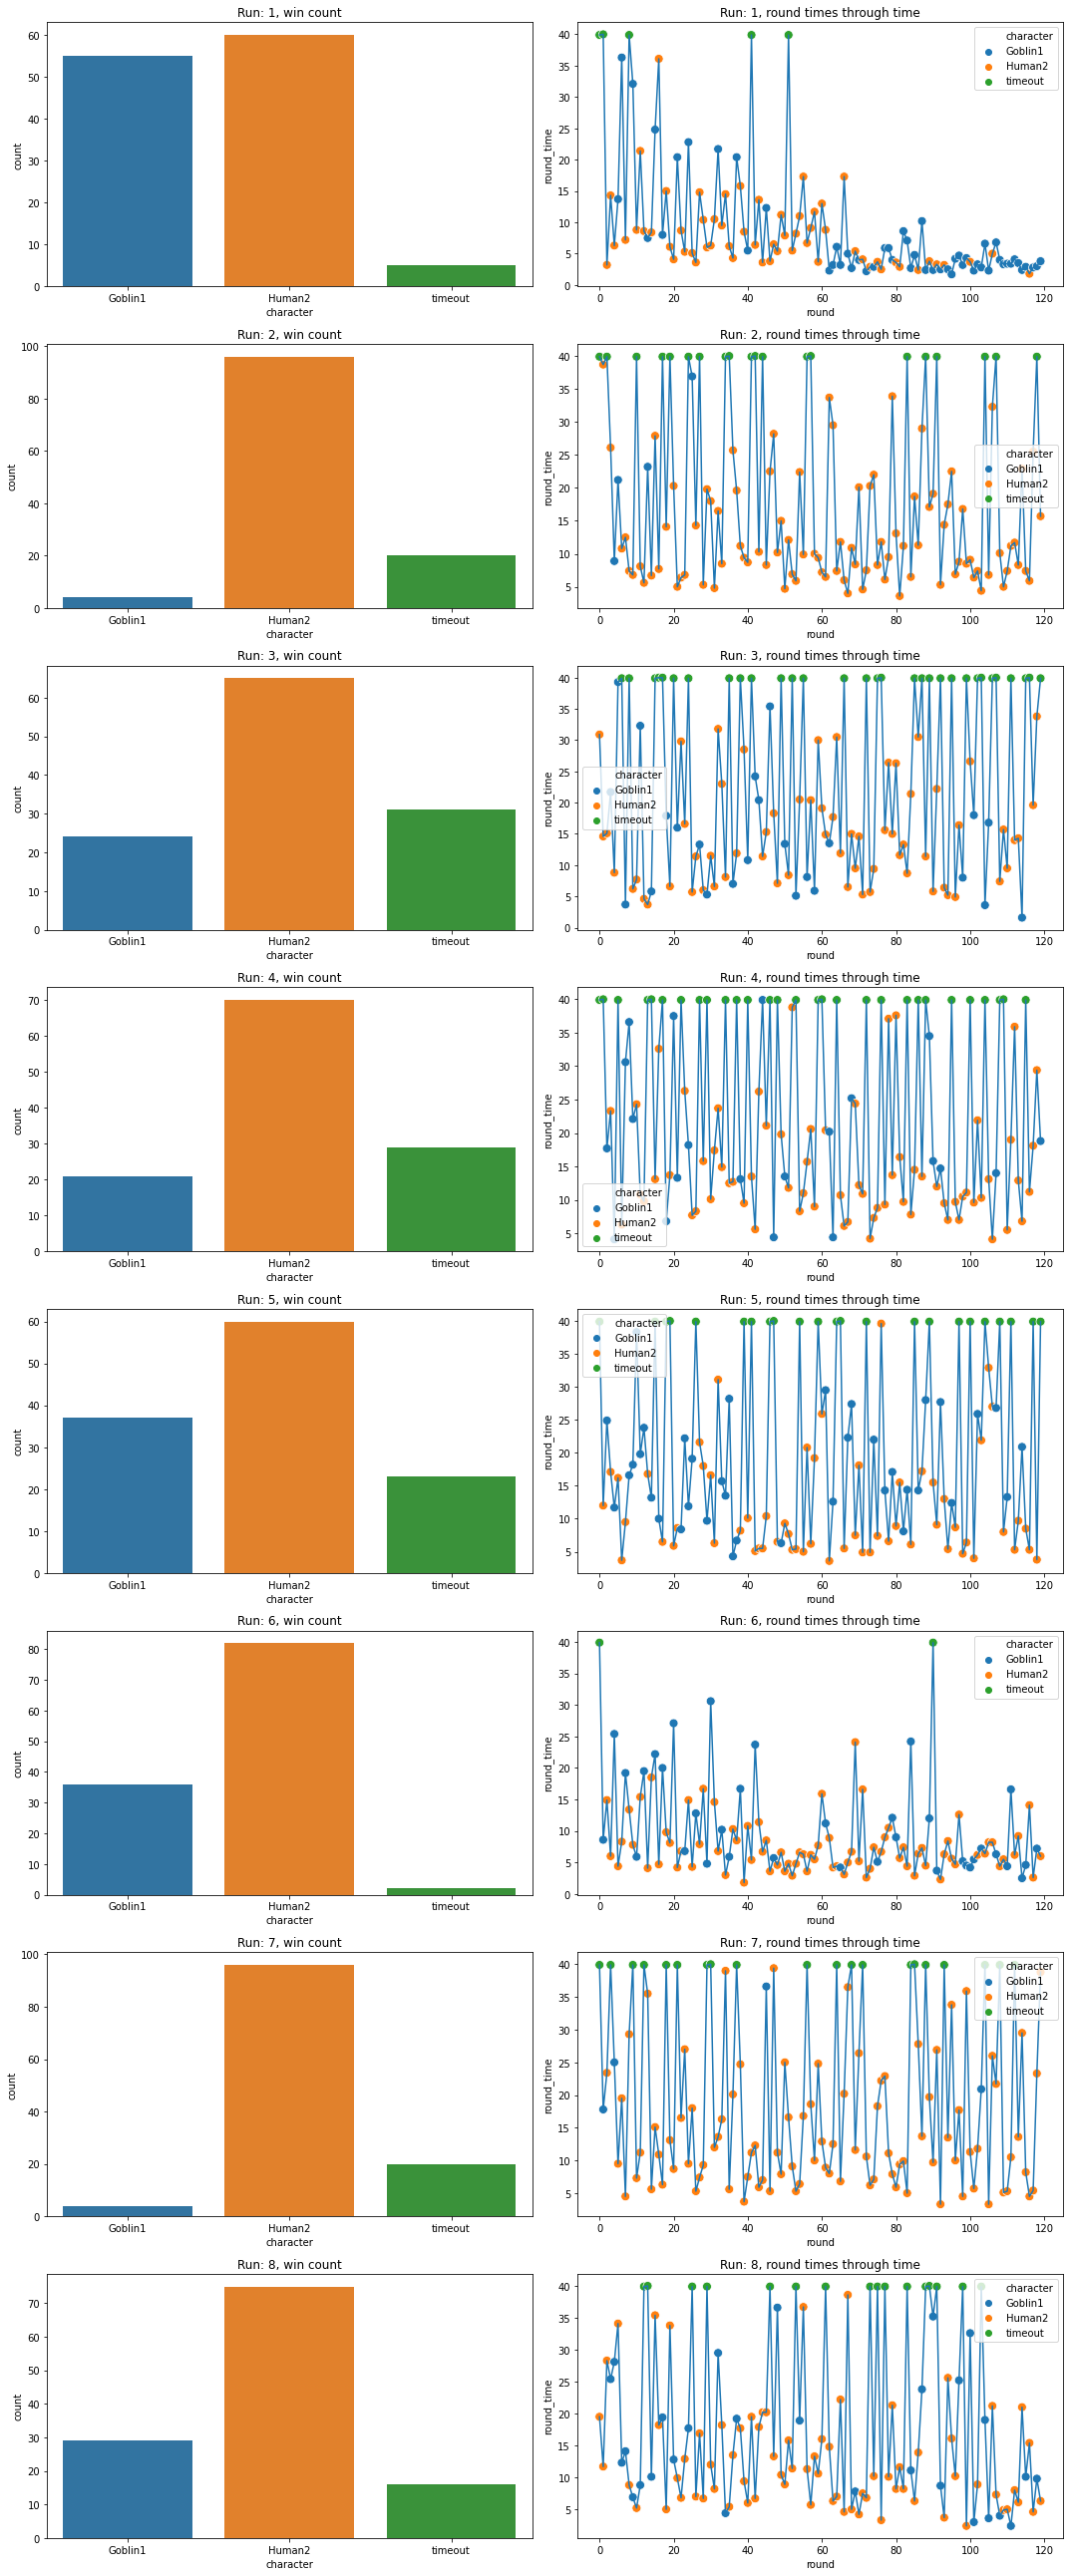

In [7]:
# Training win count histograms and win history with round times

order = sorted(["timeout"] + list(metadata[1]["characters_info"].keys()))
fig, ax = plt.subplots(runs, 2, figsize=(15, 4.5 * runs), squeeze=False)
for run in range(runs):
    ax[run][0].set_title(f"Run: {run + 1}, win count")
    winners = metadata[run + 1]["winners"]
    winners_table = pd.DataFrame({"time": terminal_times[run + 1], "character": winners}).reset_index().rename(columns={"index": "round"})
    winners_table["round_time"] = winners_table["time"] - winners_table["time"].shift(1)
    winners_table["round_time"][0] = winners_table["time"][0]
    winners_table = winners_table.iloc[0:len(terminal_times[run + 1])]
    sns.countplot(x="character", data=winners_table, order=order, ax=ax[run][0])
    ax[run][1].set_title(f"Run: {run + 1}, round times through time")
    sns.lineplot(x="round", y="round_time", data=winners_table, ax=ax[run][1])
    sns.scatterplot(x="round", y="round_time", hue="character", hue_order=order, s=80, data=winners_table, ax=ax[run][1])
plt.tight_layout()
plt.show()

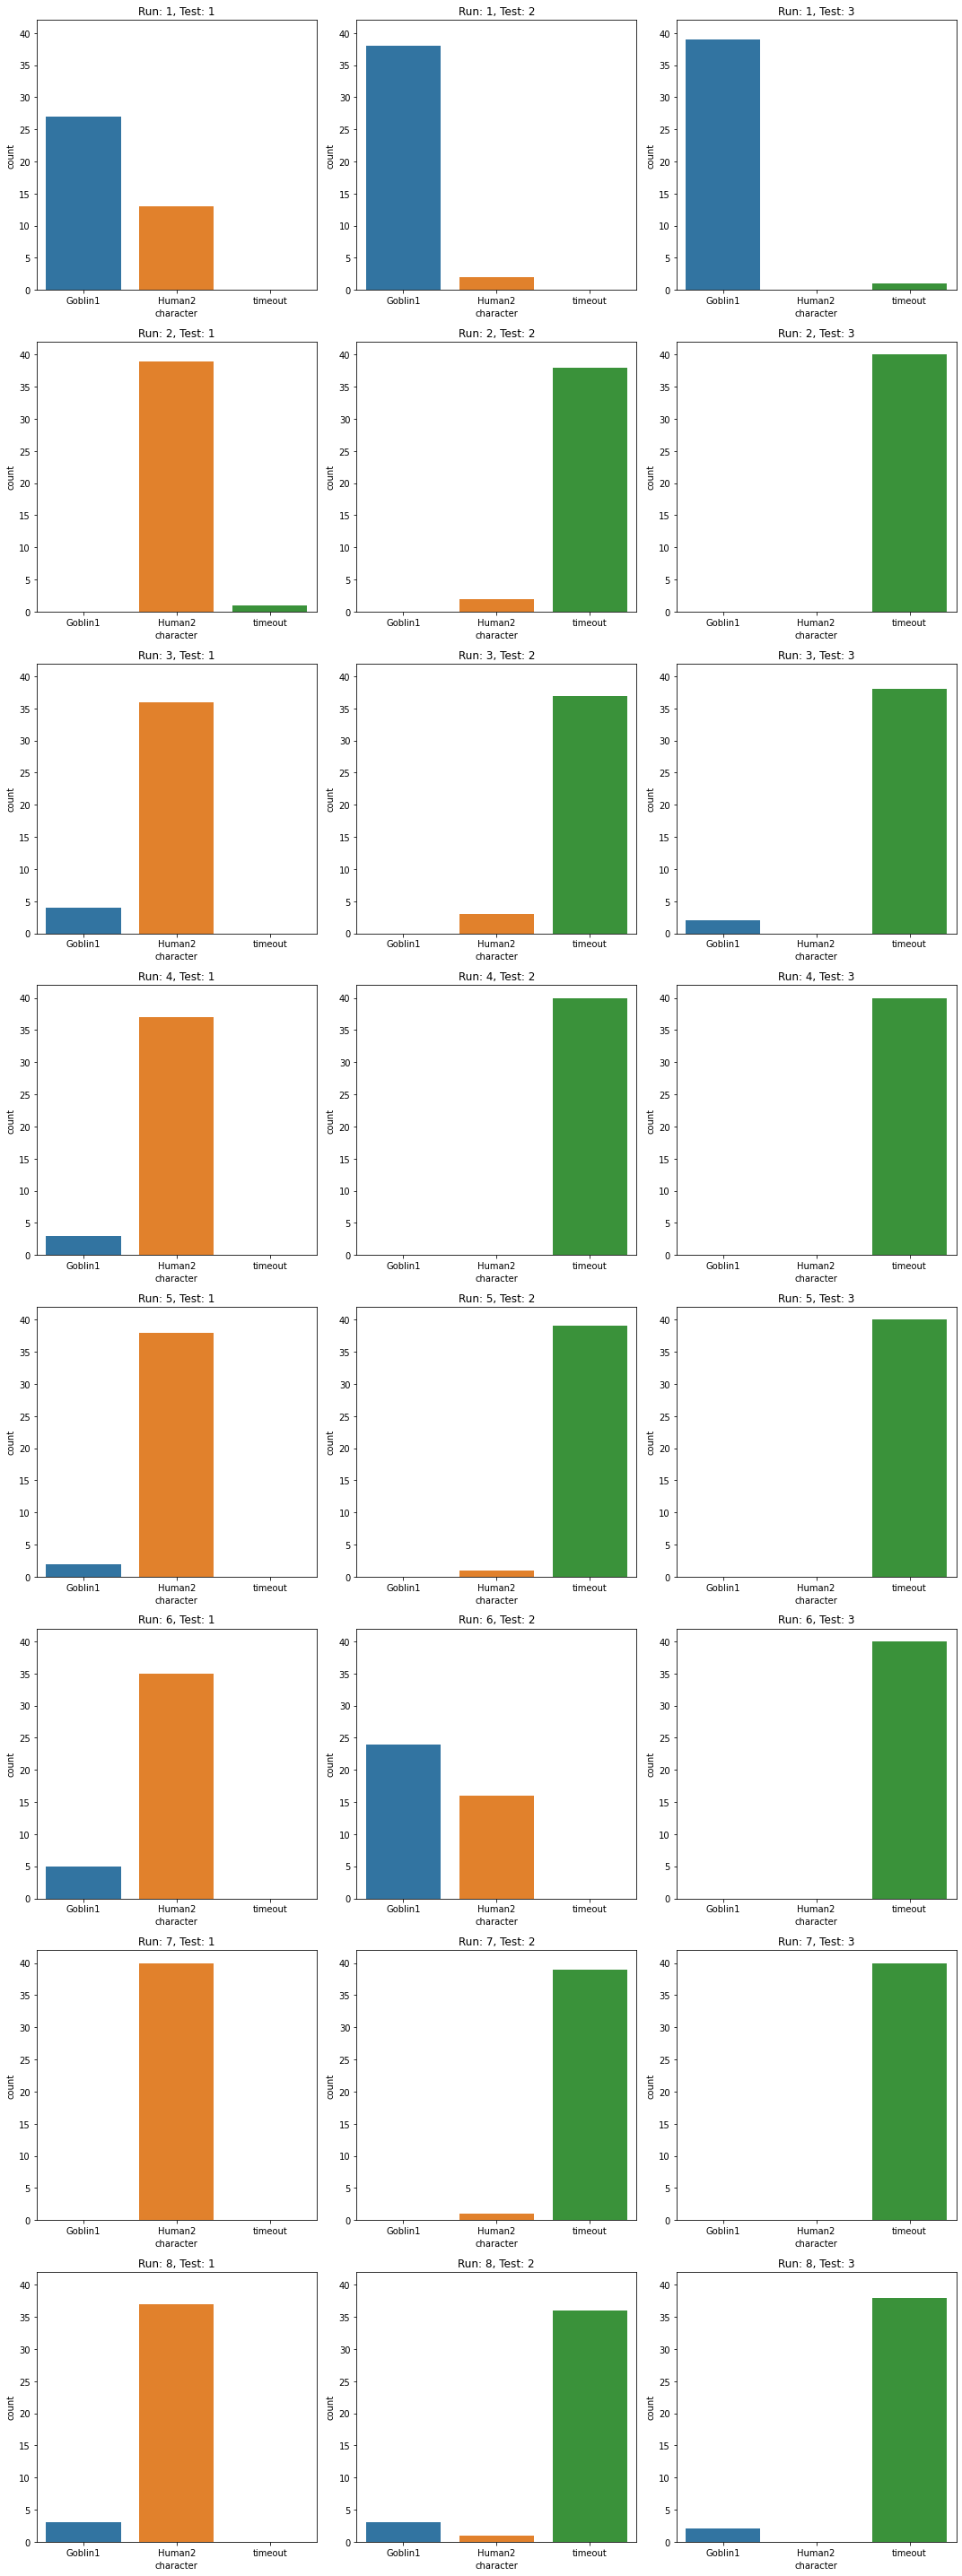

In [8]:
# Testing win count histograms

intervals = []

fig, ax = plt.subplots(runs, num_tests, figsize=(5 * num_tests, 5 * runs), squeeze=False)
for test in range(num_tests):
    order = sorted(["timeout"] + list(tests[1][test + 1]["characters_info"].keys()))
    ai_name = list(tests[1][test + 1]["params"].keys())[0]
    win_rates = []
    for run in range(runs):
        ax[run][test].set_title(f"Run: {run + 1}, Test: {test + 1}")
        test_metadata = tests[run + 1][test + 1]
        winners = test_metadata["winners"]
        rounds = len(winners)
        winners_table = pd.DataFrame({"character": winners}).reset_index().rename(columns={"index": "round"})
        sns.countplot(x="character", data=winners_table, order=order, ax=ax[run][test])
        win_rates.append(sum([winner == ai_name for winner in winners]) / rounds)
        ax[run][test].set_ylim(0, rounds + 2)
    intervals.append({
        "test": test + 1,
        "ai_name": ai_name,
        "win_rate": "({:.4f}, {:.4f}, {:.4f})".format(*mean_confidence_interval(win_rates))
    })

plt.tight_layout()
plt.show()

In [9]:
# Tests win rate confidence interval
# (maybe this is not the ideal way to calculate them, but this is better than nothing)

display(pd.DataFrame(intervals))

test  ai_name                   win_rate
0     1  Goblin1  (-0.0478, 0.1375, 0.3228)
1     2  Goblin1  (-0.1029, 0.2031, 0.5092)
2     3  Goblin1  (-0.1502, 0.1344, 0.4190)

In [10]:
# Some deprecated stisticts about training win count and times

win_rates = {c: [] for c in chars}
mean_round_times = {c: [] for c in chars}
std_round_times = {c: [] for c in chars}
num_exploit_rounds = []
chars_info = metadata[1]["characters_info"]
num_rounds = metadata[1]["rounds"]
min_time = max([info["exploration_rate_decay_time"] for info in chars_info.values()])

for run in range(runs):
    run_metadata = metadata[run + 1]
    run_data = data_sets[run + 1]
    winners = run_metadata["winners"]
    for c in chars:
        data = run_data[c]
        terminal_states = data[(data["purpuse"] == "update") & (data["terminal"] == True)]
        exploit_rounds = terminal_states[terminal_states["time"] > min_time]
        num_exploit_rounds.append(len(exploit_rounds))
        if len(exploit_rounds) == 0:
            mean_round_times[c].append(-1)
            std_round_times[c].append(-1)
            win_rates[c].append(-1)
            continue
        round_times = (exploit_rounds["time"] - exploit_rounds["time"].shift(1)).shift(-1)
        mean_round_times[c].append(round_times.mean())
        std_round_times[c].append(round_times.std())
        char_winners = pd.DataFrame({"time": terminal_states["time"].to_list(), "character": winners})
        char_winners = char_winners[char_winners["time"] > min_time]
        counts = char_winners["character"].value_counts()
        win_rates[c].append(counts.get(c, 0.0) / counts.sum())

stats_table = {"num_exploit_rounds": num_exploit_rounds}
confidence_intervals = {"win_rate": {}}
for c in chars:
    valid_win_rates = [r for r in win_rates[c] if r != -1.0]
    win_rate_interval = "({:.4f}, {:.4f}, {:.4f})".format(*mean_confidence_interval(valid_win_rates))
    confidence_intervals["win_rate"][c] = win_rate_interval
    stats_table[c + "_win_rate"] = win_rates[c]
    stats_table[c + "_mean_round_times"] = mean_round_times[c]
    stats_table[c + "_std_round_times"] = std_round_times[c]
display(pd.DataFrame(stats_table))
display(pd.DataFrame(confidence_intervals))

num_exploit_rounds  Goblin1_win_rate  Goblin1_mean_round_times  \
0                  64          0.671875                  4.465079   
1                  82          0.000000                 16.423457   
2                  81          0.172840                 21.706250   
3                  87          0.137931                 20.798838   
4                  79          0.227848                 18.650000   
5                  40          0.375000                  7.782051   
6                  83          0.024096                 18.121951   
7                  75          0.213333                 17.039189   

   Goblin1_std_round_times  
0                 2.867851  
1                11.859999  
2                13.232434  
3                13.221627  
4                13.425308  
5                 6.727355  
6                12.524958  
7                13.150737

win_rate
Goblin1  (0.0481, 0.2279, 0.4076)

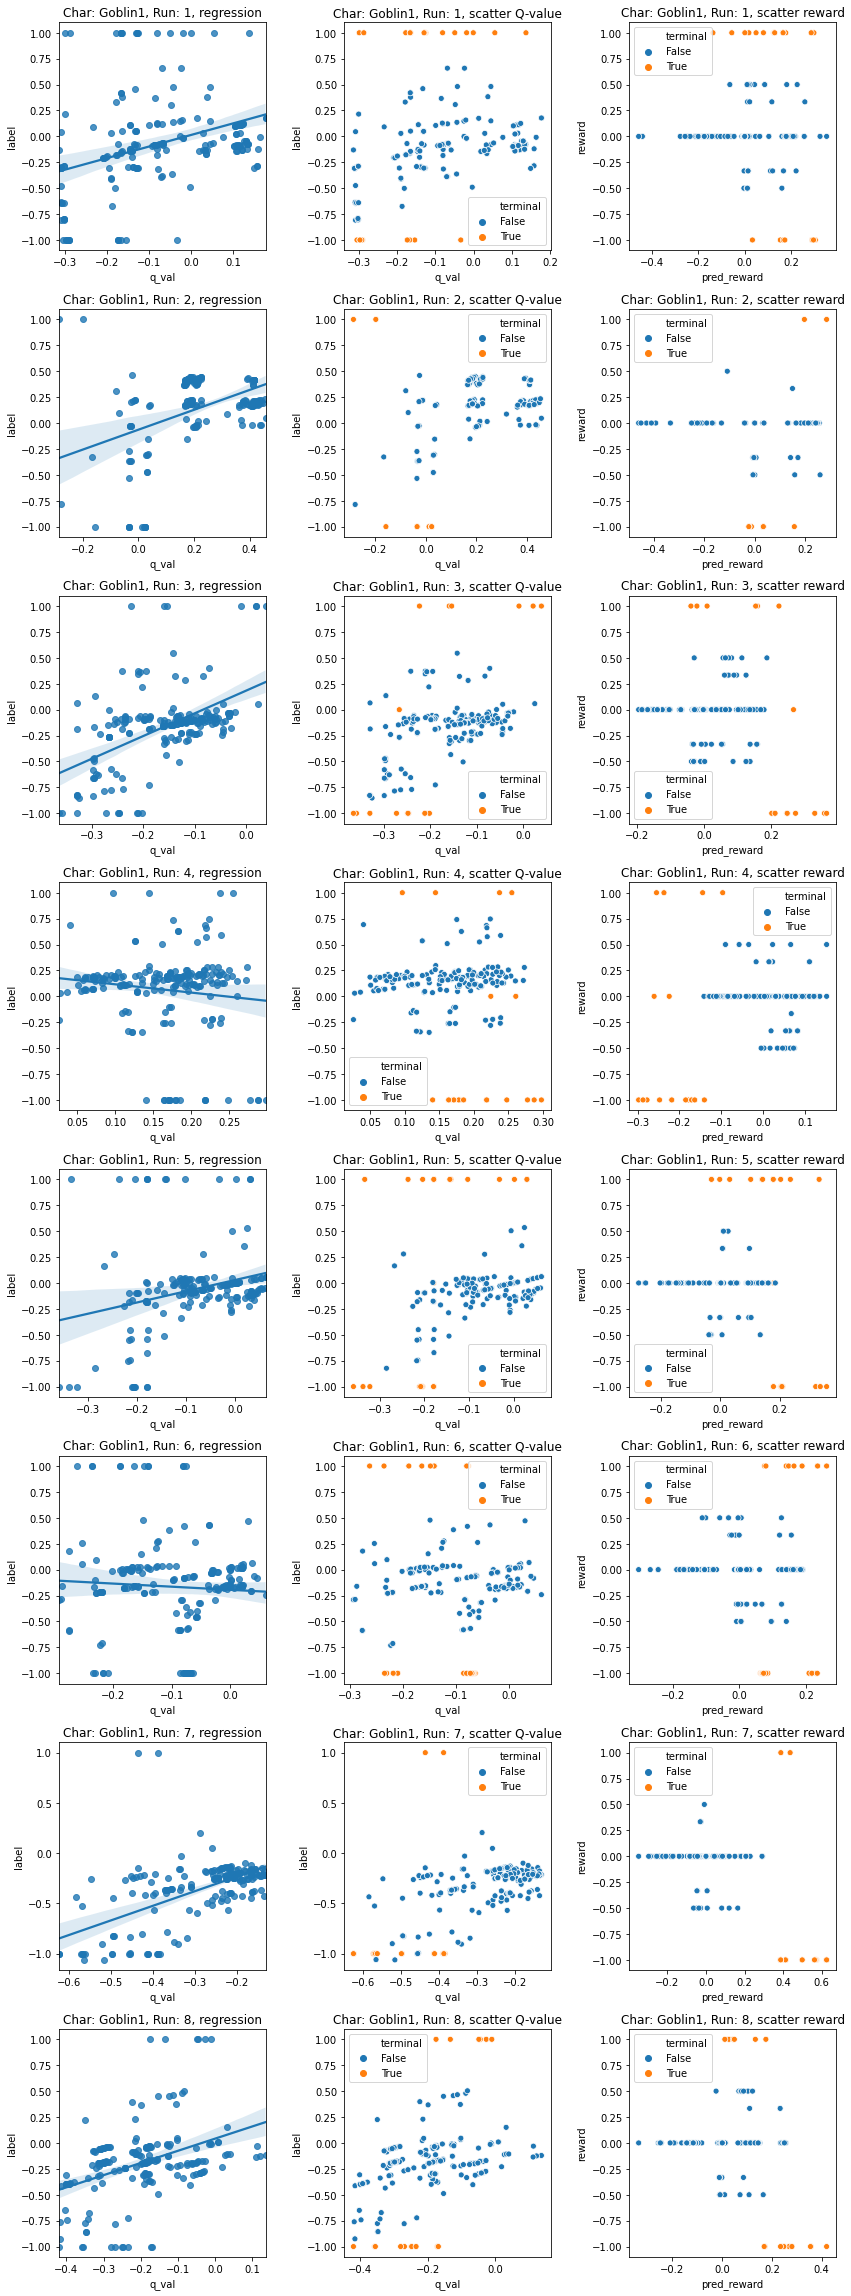

In [11]:

# Gráficos mostrando relação q-val x label no último replay

fig, ax = plt.subplots(runs, 3 * num_chars, figsize=(12 * num_chars, 4 * runs), squeeze=False)
for i in range(1, runs + 1):
    for j, char in enumerate(chars):
        this_ax = (ax[i - 1][2 * j], ax[i - 1][2 * j + 1], ax[i - 1][2 * j + 2])
        this_ax[0].set_title(f"Char: {char}, Run: {i}, regression")
        this_ax[1].set_title(f"Char: {char}, Run: {i}, scatter Q-value")
        this_ax[2].set_title(f"Char: {char}, Run: {i}, scatter reward")
        data = data_sets[i][char]
        if len(test_times[i][char]) != 0:
            last_test_time = test_times[i][char][-1]
            this_time_data = data[(data["purpuse"] == "test") & (data["time"] == last_test_time)]
            sns.regplot(x="q_val", y="label", data=this_time_data, ax=this_ax[0])
            sns.scatterplot(x="q_val", y="label", hue="terminal", data=this_time_data, ax=this_ax[1])
            sns.scatterplot(x="pred_reward", y="reward", hue="terminal", data=this_time_data, ax=this_ax[2])
plt.tight_layout()
plt.show()

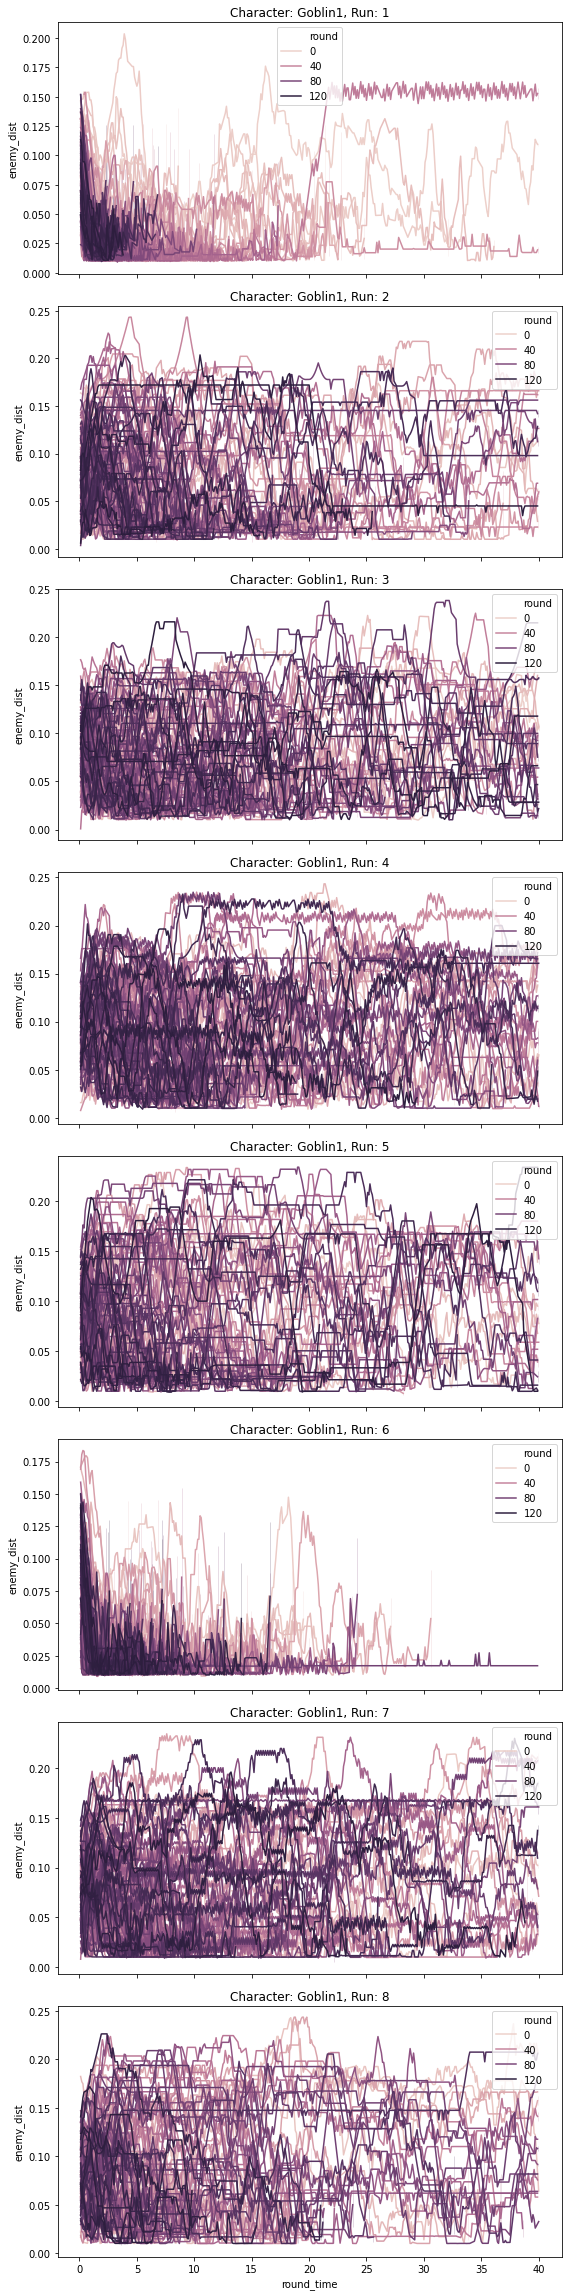

In [12]:
# Gráficos mostrando evolução da distância da IA ao inimigo conforme o tempo, com hue = número do round

fig, ax = plt.subplots(runs, num_chars, figsize=(8 * num_chars, 4 * runs), squeeze=False, sharex=True)
for i in range(1, runs + 1):
    for j, char in enumerate(chars):
        ax[i - 1][j].set_title(f"Character: {char}, Run: {i}")
        data = data_sets[i][char]
        data = data[(data["purpuse"] == "update") & (data["round"] != 0)]
        sns.lineplot(x="round_time", y="enemy_dist", hue="round", data=data, ax=ax[i - 1][j])
plt.tight_layout()
plt.show()

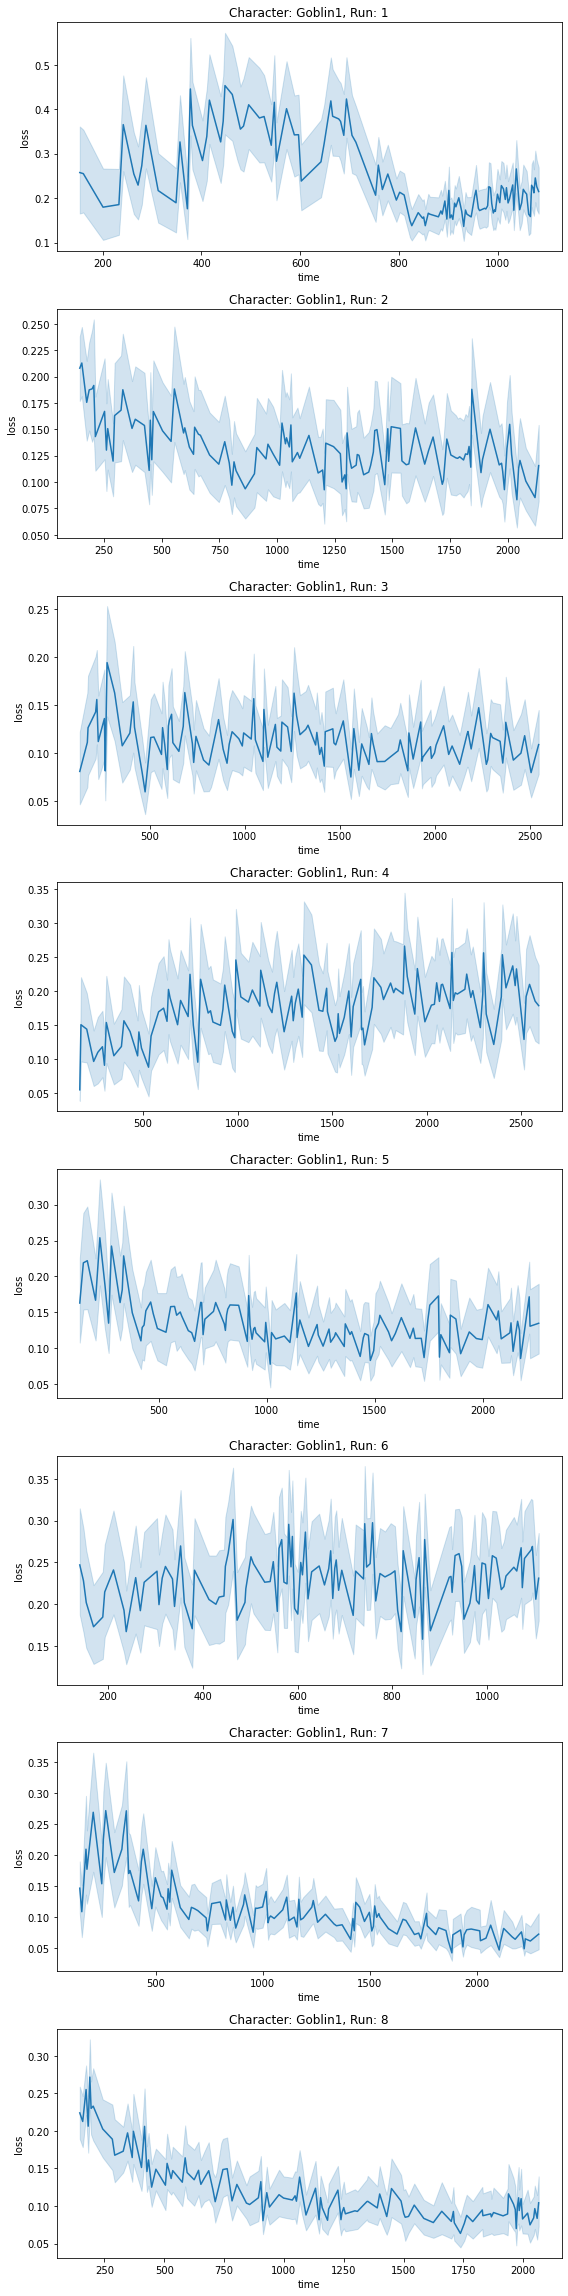

In [13]:
# Comparação da função de perda

fig, ax = plt.subplots(runs, num_chars, figsize=(8 * num_chars, 4 * runs), squeeze=False)
for i in range(1, runs + 1):
    for j, char in enumerate(chars):
        ax[i - 1][j].set_title(f"Character: {char}, Run: {i}")
        data = data_sets[i][char]
        data = data[data["purpuse"] == "test"]
        sns.lineplot(x="time", y="loss", data=data, ax=ax[i - 1][j])
plt.tight_layout()
plt.show()

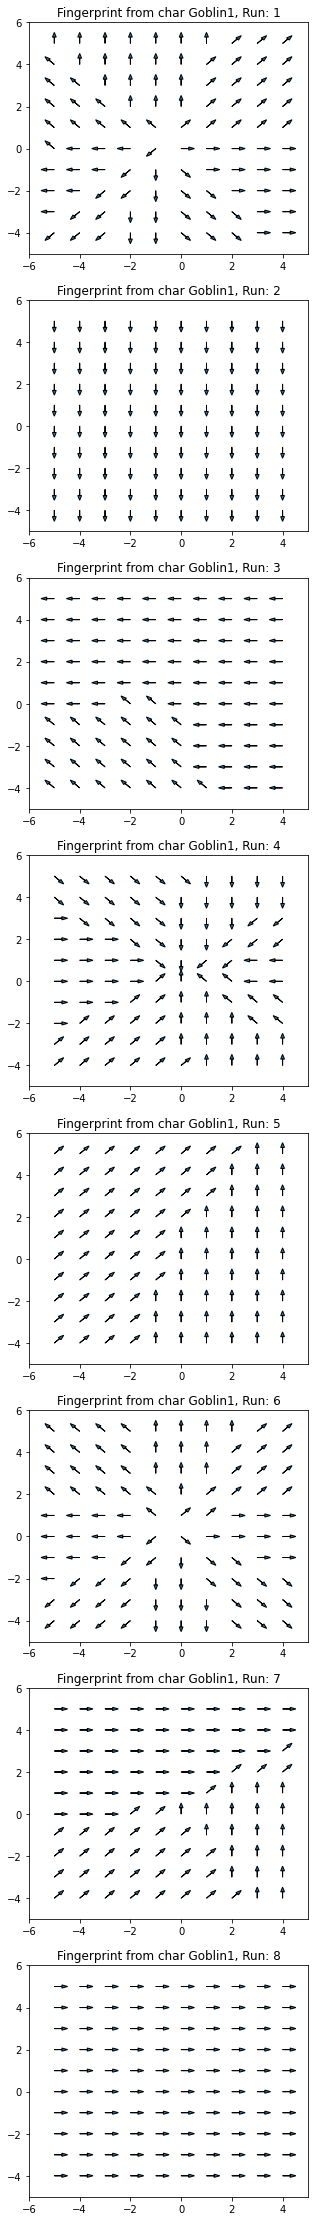

In [14]:
# Mostra a visualização das fingerprints

a = 0.3
arrows = {
    "walk_right": (a, 0.0),
    "walk_up_right": (a * np.sqrt(2) / 2, a * np.sqrt(2) / 2),
    "walk_up": (0.0, a),
    "walk_up_left": (- a * np.sqrt(2) / 2, a * np.sqrt(2) / 2),
    "walk_left": (- a, 0.0),
    "walk_down_left": (- a * np.sqrt(2) / 2, - a * np.sqrt(2) / 2),
    "walk_down": (0.0, - a),
    "walk_down_right": (a * np.sqrt(2) / 2, - a * np.sqrt(2) / 2),
    "idle": (0.0, 0.0),
    "attack": (0.0, 0.0)
}

fig, ax = plt.subplots(runs, 1, figsize=(5, 5 * runs))
for run in range(0, runs):
    fps = fingerprints[run + 1]
    for name, fp in fps.items():
        ax[run].set_title(f"Fingerprint from char {name}, Run: {run + 1}")
        for i, col in enumerate(fp):
            for j, el in enumerate(col):
                x = i - 5
                y = 5 - j
                if el == "idle":
                    ax[run].add_artist(plt.Circle((x, y), a, color='b'))
                elif el == "attack":
                    ax[run].add_artist(plt.Rectangle((x, y), a, a, color='r'))
                else:
                    dx, dy = arrows[el]
                    ax[run].arrow(x, y, dx, dy, head_width=0.15)
        ax[run].set_xlim(-6.0, 5.0)
        ax[run].set_ylim(-5.0, 6.0)
plt.show()

In [15]:
sizes_table = pd.DataFrame(index=["update", "test", "replay"])
for run in range(1, runs + 1):
    data = data_sets[run]["Goblin1"]
    sizes_table["Run %d" % run] = [len(data[data["purpuse"] == "update"]),
                                   len(data[data["purpuse"] == "test"]),
                                   len(data[data["purpuse"] == "replay"])]
display(sizes_table)

Run 1  Run 2  Run 3  Run 4  Run 5  Run 6  Run 7  Run 8
update   9088  19658  22725  23877  20304   9678  21120  18715
test    22800  23400  23000  23000  22600  22400  23200  23000
replay  26336  59552  68928  73440  61632  28192  64384  56224

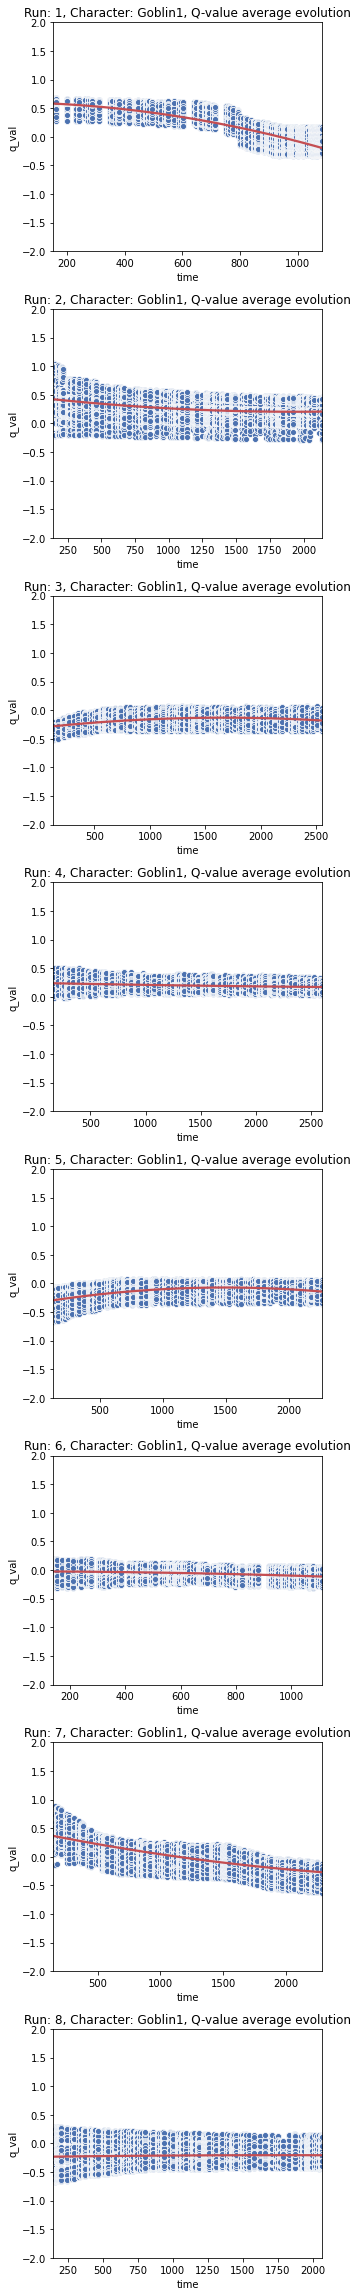

In [16]:
fig, ax = plt.subplots(runs, num_chars, figsize=(5 * num_chars, 4 * runs), squeeze=False)
for run in range(1, runs + 1):
    for i, char in enumerate(chars):
        data = data_sets[run][char]
        data = data[data["purpuse"] == "test"]
        this_ax = ax[run - 1][i]
        this_ax.set_title(f"Run: {run}, Character: {char}, Q-value average evolution")
        sns.scatterplot(x="time", y="q_val", data=data, color="#4C72B0", ax=this_ax)
        sns.regplot(x="time", y="q_val", data=data, order=2, color="#C44E52", scatter=False, ax=this_ax)
        this_ax.set_ylim(-2.0, 2.0)
    
plt.tight_layout()
plt.show()

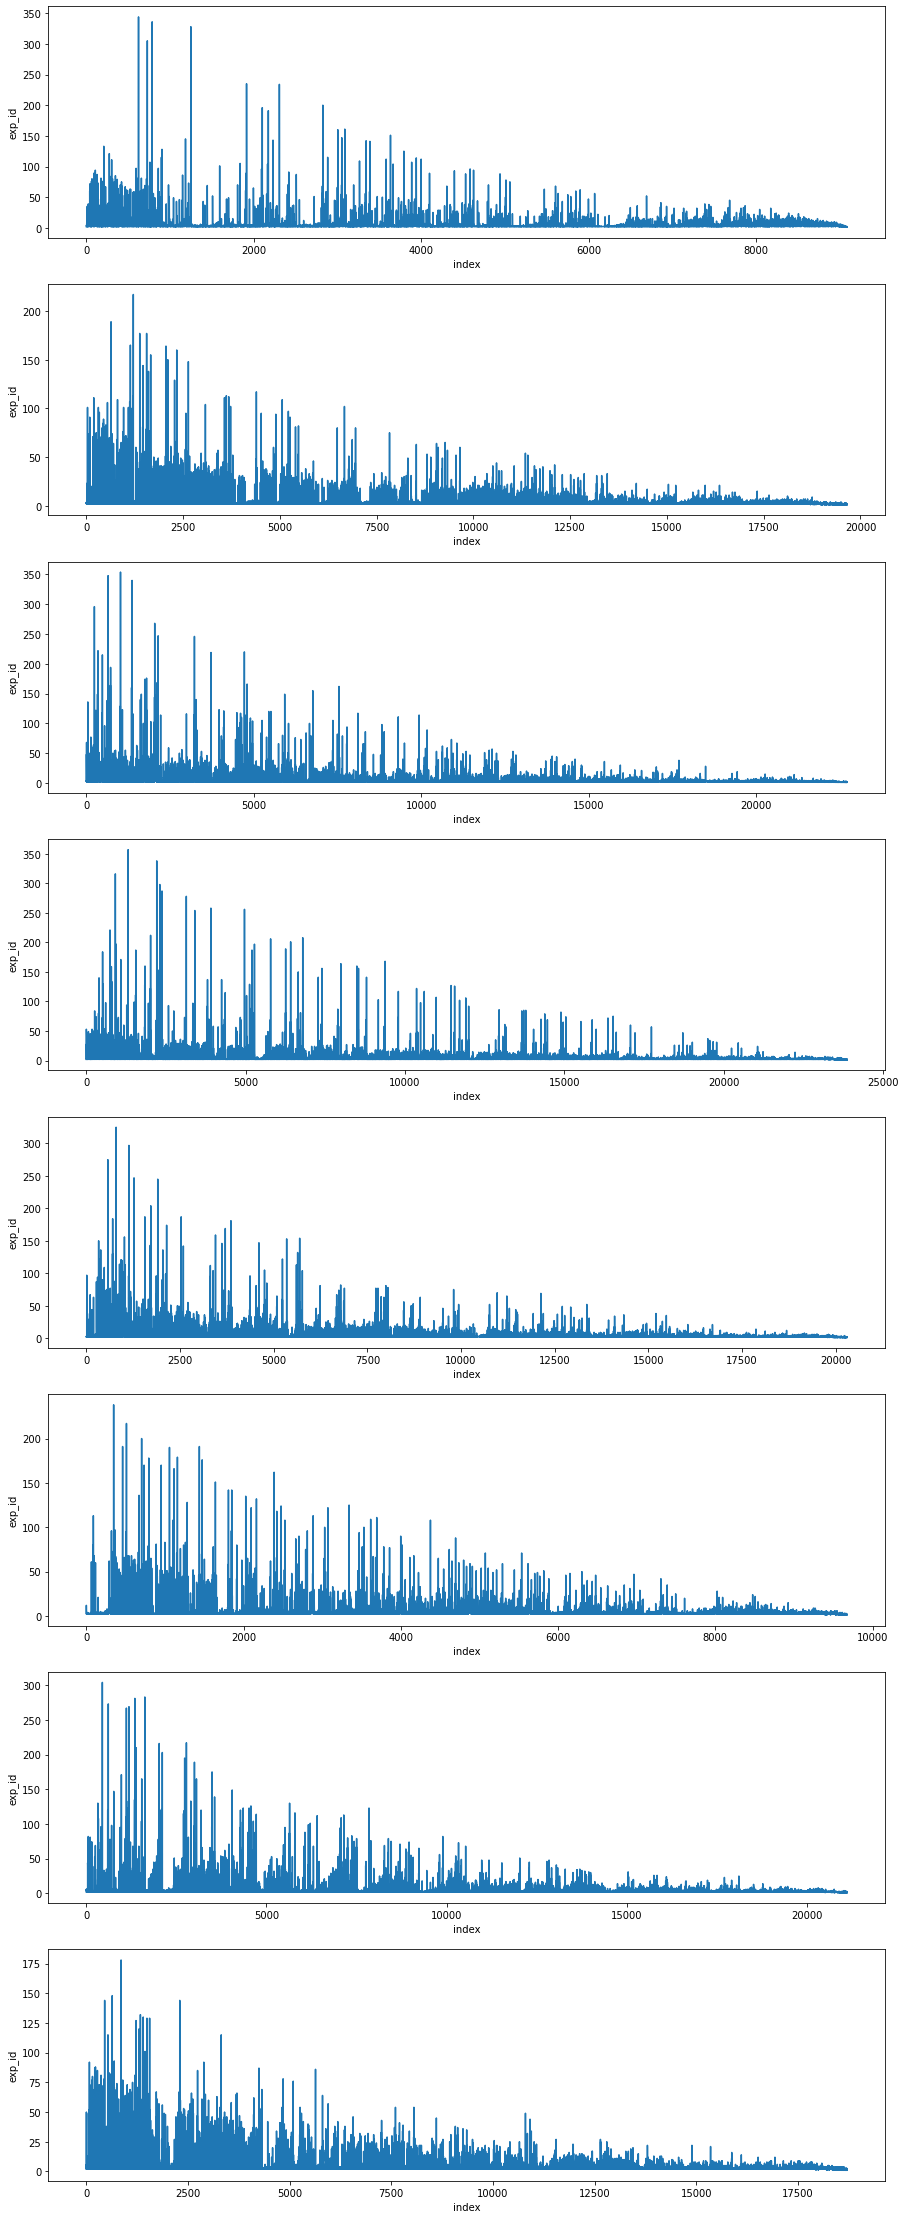

In [17]:
# Mostra a quantidade de vezes que cada experiência foi revista.
# Quanto menor o índice da recompensa, mais antiga ela é.

fig, ax = plt.subplots(runs, 1, figsize=(15, 5 * runs))
for run in range(1, runs + 1):
    data = data_sets[run]["Goblin1"]
    id_count_df = data["exp_id"].value_counts().to_frame().reset_index()
#     sns.distplot(data["exp_id"], bins=np.arange(id_count_df["index"].size + 1), kde=False, ax=ax[run - 1])
    sns.lineplot(x=id_count_df["index"], y=id_count_df["exp_id"], ax=ax[run - 1])
plt.show()

In [18]:
id_mean_table = pd.DataFrame(index=["mean_sample"])
for run in range(1, runs + 1):
    data = data_sets[run]["Goblin1"]
    id_count = data["exp_id"].value_counts()
    id_mean_table["Run %d" % run] = [id_count.mean()]
display(id_mean_table)

Run 1     Run 2     Run 3     Run 4     Run 5     Run 6  \
mean_sample  6.40669  5.219758  5.045237  5.039033  5.148542  6.227526   

               Run 7     Run 8  
mean_sample  5.14697  5.233182

In [69]:
# Distribuição de recompensa

